In [1]:
from analyzer.io.trajectory_parser import parse_trajectory
from analyzer.data.geometry import Geometry

import pygeos
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import numpy as np
import pandas as pd

# Setup geometry & measurement area

In [21]:
geometry = pygeos.polygons([(-10, -2), (-10, 7), (10, 7), (10, -2), (-10, -2)])

geometry_pita = Geometry(geometry)
geometry_pita.add_obstacle(pygeos.polygons([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)]))
geometry_pita.add_obstacle(pygeos.polygons([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

ma = pygeos.polygons([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = pygeos.linestrings([(0, 0), (0, 5)])

direction = np.array([-1, 0])

traj = parse_trajectory("demos/uni-directional/traj_UNI_CORR_500_01.txt")

# Density

## Classic density

In [ ]:
from analyzer.methods.density_calculator import compute_classic_density

classic_density = compute_classic_density(traj.data, ma)
classic_density

In [ ]:
classic_density.reset_index().plot.line(x="frame", y="classic density")

## Voronoi density

In [ ]:
from analyzer.methods.density_calculator import compute_voronoi_density

density_voronoi, individual = compute_voronoi_density(traj.data, ma, geometry_pita)

In [ ]:
density_voronoi

In [ ]:
individual

In [ ]:
density_voronoi.reset_index().plot.line(x="frame", y="voronoi density")

In [ ]:
density_voronoi_cutoff, individual_cutoff = compute_voronoi_density(
    traj.data, ma, geometry_pita, 1.0, 12
)

In [ ]:
density_voronoi_cutoff.reset_index().plot.line(x="frame", y="voronoi density")

## Comparision

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=3,
)
plt.plot(
    density_voronoi.reset_index().frame, density_voronoi["voronoi density"], label="voronoi", lw=3
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff["voronoi density"],
    label="voronoi cutoff",
    lw=3,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.legend()
plt.grid()
plt.show()

## Plot voronoi cells

In [ ]:
frame_start = 1200

for frame in range(frame_start, frame_start + 100, 20):
    fig = plt.figure(figsize=(15, 20))
    ax1 = fig.add_subplot(121, aspect="equal")

    ax1.plot(*pygeos.to_shapely(geometry).exterior.xy, color="k")
    ax1.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    df_frame = individual[individual.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])
    for _, row in df_frame.iterrows():
        p = ax1.plot(*pygeos.to_shapely(row[6]).exterior.xy)
        ax1.scatter(row[2], row[3])
        ax1.add_patch(
            PolygonPatch(
                pygeos.to_shapely(row[6]), alpha=0.1, zorder=2, fc=p[-1].get_color(), ec="none"
            )
        )
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2 = fig.add_subplot(122, aspect="equal")

    ax2.plot(*pygeos.to_shapely(geometry).exterior.xy, color="k")
    ax2.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    df_frame_cutoff = individual_cutoff[individual_cutoff.frame == frame]
    df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=["ID", "frame"])
    for _, row in df_frame_cutoff.iterrows():
        p = ax2.plot(*pygeos.to_shapely(row[6]).exterior.xy)
        ax2.scatter(row[2], row[3])
        ax2.add_patch(
            PolygonPatch(
                pygeos.to_shapely(row[6]), alpha=0.1, zorder=2, fc=p[-1].get_color(), ec="none"
            )
        )
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    fig.tight_layout()
    plt.show()

## Passing density (individual)

In [ ]:
from analyzer.methods.density_calculator import compute_passing_density
from analyzer.methods.method_utils import compute_frame_range_in_area

frames_in_area = compute_frame_range_in_area(traj.data, ma)
passing_density = compute_passing_density(classic_density, frames_in_area)
passing_density

# Velocity

In [7]:
from analyzer.methods.velocity_calculator import compute_individual_velocity

individual_speed = compute_individual_velocity(traj.data, traj.frame_rate, 5)
individual_speed

,ID,frame,start,end,start_frame,end_frame,distance,speed
0,1,98,POINT (4.601 1.891),POINT (4.271 1.949),98.0,103.0,0.335516,1.677581
1,1,99,POINT (4.536 1.898),POINT (4.214 1.954),99.0,104.0,0.326538,1.632689
2,1,100,POINT (4.447 1.93),POINT (4.156 1.954),100.0,105.0,0.291498,1.457490
3,1,101,POINT (4.386 1.936),POINT (4.099 1.955),101.0,106.0,0.288426,1.442132
4,1,102,POINT (4.328 1.945),POINT (4.032 1.965),102.0,107.0,0.297187,1.485936
...,...,...,...,...,...,...,...,...
25531,148,872,POINT (-4.896 1.455),POINT (-5.163 1.484),867.0,872.0,0.268283,1.341414
25532,148,873,POINT (-4.946 1.466),POINT (-5.216 1.483),868.0,873.0,0.270616,1.353079
25533,148,874,POINT (-4.999 1.476),POINT (-5.268 1.48),869.0,874.0,0.269621,1.348107
25534,148,875,POINT (-5.056 1.482),POINT (-5.316 1.479),870.0,875.0,0.260316,1.301581


In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
individual_speed_direction = compute_individual_velocity(traj.data, traj.frame_rate, 5, direction)
individual_speed_direction

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

## Mean speed (all)

In [ ]:
from analyzer.methods.velocity_calculator import compute_mean_velocity_per_frame

mean_speed, individual_speed = compute_mean_velocity_per_frame(traj.data, traj.frame_rate, 10)
mean_speed

In [ ]:
mean_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
mean_speed_direction, individual_speed_direction = compute_mean_velocity_per_frame(
    traj.data, traj.frame_rate, 5, direction
)
mean_speed_direction

## Mean speed (in measurement area)

In [ ]:
from analyzer.methods.method_utils import get_peds_in_area
from analyzer.methods.velocity_calculator import compute_mean_velocity_per_frame

peds_in_area = get_peds_in_area(traj.data, ma)
mean_speed_area, individual_speed_area = compute_mean_velocity_per_frame(
    peds_in_area, traj.frame_rate, 5
)

In [ ]:
mean_speed_area.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
mean_speed_area_direction, individual_speed_area_direction = compute_mean_velocity_per_frame(
    peds_in_area, traj.frame_rate, 5, direction
)

In [ ]:
individual_speed_area_direction

In [ ]:
mean_speed_area_direction.reset_index().plot.scatter(x="frame", y="speed")

## Voronoi speed

In [ ]:
from analyzer.methods.density_calculator import (
    _compute_individual_voronoi_polygons,
    _compute_intersecting_polygons,
)
from analyzer.methods.velocity_calculator import (
    compute_individual_velocity,
    compute_voronoi_velocity,
)

In [ ]:
individual_voronoi = _compute_individual_voronoi_polygons(traj.data, geometry_pita)
intersecting_voronoi = _compute_intersecting_polygons(individual_voronoi, ma)

In [ ]:
voronoi_velocity, individual_velocity = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma
)
voronoi_velocity

In [ ]:
voronoi_velocity.reset_index().plot.scatter(x="frame", y="voronoi speed")

In [ ]:
voronoi_velocity_direction, individual_velocity_direction = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma, direction
)
voronoi_velocity_direction

## Comparison mean velocity vs voronoi velocity

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(voronoi_velocity.reset_index().frame, voronoi_velocity, label="voronoi")
plt.scatter(
    voronoi_velocity_direction.reset_index().frame,
    voronoi_velocity_direction,
    label="voronoi direction",
)
plt.scatter(mean_speed_area.reset_index().frame, mean_speed_area, label="classic")
plt.scatter(
    mean_speed_area_direction.reset_index().frame,
    mean_speed_area_direction,
    label="classic direction",
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

## Passing speed (individual)

In [25]:
from analyzer.methods.velocity_calculator import compute_passing_speed
from analyzer.methods.method_utils import compute_frame_range_in_area

frames_in_area = compute_frame_range_in_area(traj.data, ml, -0.1)
# passing_speed = compute_passing_speed(frames_in_area, traj.frame_rate)
# passing_speed
frames_in_area

/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in within
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,frame_start,frame_end,start,end


# Flow

## N-t diagram

In [17]:
from analyzer.methods.flow_calculator import compute_n_t

nt, crossing = compute_n_t(traj.data, ml, traj.frame_rate)

<AxesSubplot:xlabel='Time [s]'>

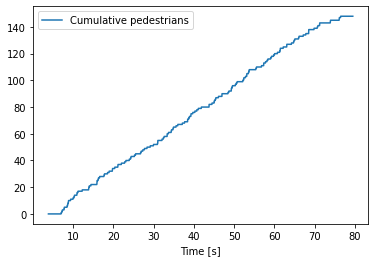

In [4]:
nt.plot(x="Time [s]")

## Flow

In [19]:
from analyzer.methods.flow_calculator import compute_flow

delta_t = 100
flow = compute_flow(nt, crossing, individual_speed, delta_t, traj.frame_rate)
flow

,Flow rate(1/s),Mean velocity(m/s)
0,4.000000,1.657200
1,1.744186,1.632446
2,2.212389,1.507955
3,1.822917,1.513848
4,1.941748,1.513635
5,1.941748,1.458399
6,2.577320,1.398669
7,2.020202,1.447868
8,2.364865,1.472313
9,1.953125,1.411591
